# Classify data
---

In [2]:
import numpy as np
import random

In [3]:
small_mix = "000,004,006,009,010,011,014,015,016,018,021,022,026,029,033,034,036,039,040,041,046,051,052,054,057,059,061,062,065,066,071,075,076,082,083,085,086,087,095,096,097,098,100,104,105,108,111,113,115,116,117,118,119,122,123,126,128,131,132,136,138,140,142,144,147,148,150,151,153,154,156,157,158,159,160,163,166,167,168,169,171,174,175,176,177,198,201,203,204,207,208"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,109,139,149,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,042,056,070,079,088,114,135"
small_black = "001,002,003,007,013,017,019,027,031,032,035,038,043,044,045,048,050,053,064,068,072,077,080,089,090,091,094,099,101,103,106,110,121,124,127,129,130,133,146,162,164,170,173,185,187,196"

hard_mix = "020,023,049,063,081,120,156,191,209"

In [4]:
random.shuffle(smallMix)
random.shuffle(bigMix)
random.shuffle(bigBlack)
random.shuffle(smallBlack)
random.shuffle(hardMix)

NameError: name 'smallMix' is not defined

In [ ]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,049,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,156,191,209,057,098,150,057,098,150"
mix_with_black = "015,026,058,060,069,074,082,084,093,102,112,119,124,125,134,137,141,145,152,155,156,161,178,182,183,190,195,200"
special = "165,194,206,041,205,184,005,015,154,037,021,188,193,143,208,180,046"

In [ ]:
a = len(true_small_mix.split(","))
b = len(small_white.split(","))
c = len(big_mix.split(","))
d = len(big_black.split(","))
e = len(small_black.split(","))
f = len(hard_mix.split(","))
g = len(mix_with_black.split(","))
h = len(special.split(","))
print(b)
print(a+b+c+d+e+f+g+h)

In [ ]:
a = true_small_mix.split(",")
b = small_white.split(",")
c = big_mix.split(",")
d = big_black.split(",")
e = small_black.split(",")
f = hard_mix.split(",")
g = mix_with_black.split(",")
h = special.split(",")

print(sorted(a+b+c+d+e+f+g+h))
print(len(sorted(a+b+c+d+e+f+g+h)))
ss = sorted(a+b+c+d+e+f+g+h)

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

#['015', '041', '049', '082', '102', '124', '156', '178']
loss = []
count = []
overlap = []
ignorePatient = ["005","151","165","194"]
for x in range(210):
    ss.count(str(x).zfill(3))
for x in range(210):
#     if str(x).zfill(3) in ignorePatient:
#         continue
        
    cnt = 0
    cnt += a.count(str(x).zfill(3))
    cnt += b.count(str(x).zfill(3))
    cnt += c.count(str(x).zfill(3))
    cnt += d.count(str(x).zfill(3))
    cnt += e.count(str(x).zfill(3))
    cnt += f.count(str(x).zfill(3))
    cnt += g.count(str(x).zfill(3))
    cnt += h.count(str(x).zfill(3))
    
    if cnt == 0:
        loss.append(str(x).zfill(3))
    
    if cnt>1:
        overlap.append(str(x).zfill(3))
        
    count.append(cnt)
print(overlap)
print(loss)
print(np.where(np.array(count)>0, True, False).sum())
print(count)

In [2]:
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [3]:
ignorePatient = [5,151,165,194]

In [115]:
#df = pd.DataFrame(columns = ["id", "slice number", "tag", "mean", "std", "var", "max", "min"])
df = pd.DataFrame(columns = ["id", "slice number", "tag"])
df.set_index(["id", "slice number", "tag"], inplace=True)
# df.loc[(0,0,"s"), "a"] = 100
# df.loc[(0,1,"a"), "a"] = 200
# df.loc[(0,1,"s"), "a"] = 300
# df.loc[(0,2,"s"), "a"] = 400
# df.loc[(0,2,"a"), "a"] = 500
print(df)

Empty DataFrame
Columns: [id, slice number, tag]
Index: []


In [166]:
sliceNumbers = 0
for x in range(210):
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumbers += len(labelArray[:,0,0])
    
    
df = pd.DataFrame(index=range(sliceNumbers*2))
print(df)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[214668 rows x 0 columns]


In [169]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

         id  slice number     tag  Mean  Std  Var  Max  Min
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN
...     ...           ...     ...   ...  ...  ...  ...  ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN

[214668 rows x 8 columns]
                         Mean  Std  Var  Max  Min
id  slice number tag                             
0   0            kidney   NaN  NaN  NaN  NaN  NaN
    1            kidney   NaN  NaN  NaN  NaN  NaN
    2            kidney   NaN  NaN  NaN  NaN  NaN
   

         id  slice number     tag  Mean  Std  Var  Max  Min  Size
0         0             0  kidney   NaN  NaN  NaN  NaN  NaN     0
1         0             1  kidney   NaN  NaN  NaN  NaN  NaN     0
2         0             2  kidney   NaN  NaN  NaN  NaN  NaN     0
3         0             3  kidney   NaN  NaN  NaN  NaN  NaN     0
4         0             4  kidney   NaN  NaN  NaN  NaN  NaN     0
...     ...           ...     ...   ...  ...  ...  ...  ...   ...
214663  209           506  cancer   NaN  NaN  NaN  NaN  NaN     0
214664  209           507  cancer   NaN  NaN  NaN  NaN  NaN     0
214665  209           508  cancer   NaN  NaN  NaN  NaN  NaN     0
214666  209           509  cancer   NaN  NaN  NaN  NaN  NaN     0
214667  209           510  cancer   NaN  NaN  NaN  NaN  NaN     0

[214668 rows x 9 columns]
         id  slice number     tag        Mean        Std          Var  \
162       0           162  kidney  -37.253151   9.672718    93.561468   
163       0           163  kidney  

In [185]:
df = pd.read_csv("sagital.csv")
kidSize = []
canSize = []

for x in range(210):
    
    if x in ignorePatient:
        continue
        
    imagePath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "imaging.nii.gz")
    labelPath = os.path.join("E:/kits19/data/case_00" + str(x).zfill(3), "segmentation.nii.gz")
    image = sitk.ReadImage(imagePath)
    label = sitk.ReadImage(labelPath)
    imageArray = sitk.GetArrayFromImage(image)
    labelArray = sitk.GetArrayFromImage(label)
    
    sliceNumber = len(labelArray[:,0,0])
    
    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kSize = np.where(labArray==1, True, False).sum()
        cSize = np.where(labArray==2, True, False).sum()
        
        kidSize.append(kSize)
        canSize.append(cSize)
        

df["Size"] = kidSize + canSize


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital2.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [102]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import SimpleITK as sitk
import os
import numpy as np

In [103]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,191,209,057,098,150"
mix_with_black = "015,026,058,060,069,074,084,093,112,119,125,134,137,141,145,152,155,156,161,182,183,190,195,200"
special = "165,194,206,205,184,005,154,037,021,188,193,143,208,180,046"

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

In [104]:
df = pd.read_csv("dfAboutKidneyAndCancer.csv")
print(df)

       Unnamed: 0   id  slice number     tag        Mean        Std  \
0             162    0           162  kidney  -37.253151   9.672718   
1             163    0           163  kidney   37.572537  49.860718   
2             164    0           164  kidney   85.865282  86.790756   
3             165    0           165  kidney   99.003225  94.184951   
4             166    0           166  kidney  129.435100  84.773216   
...           ...  ...           ...     ...         ...        ...   
52505      214501  209           344  cancer   62.450544  56.845241   
52506      214502  209           345  cancer   75.063078  58.664732   
52507      214503  209           346  cancer   89.271236  35.083031   
52508      214504  209           347  cancer   77.540750  10.665388   
52509      214505  209           348  cancer   73.605345   9.064534   

               Var         Max         Min  Size  
0        93.561468  -11.861316  -11.861316    22  
1      2486.091249  127.743541  127.743541   

In [105]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
c = []
for x in range(210):
    sx = str(x).zfill(3)
    if sx in ignorePatient:
        continue
    if sx in trueSmallMix:#red
        c.append(0)
    if sx in smallWhite:#blue
        c.append(1)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(3)
    if sx in smallBlack:#black
        c.append(4)
    if sx in hardMix:#"gray"
        c.append(5)
    if sx in mixWithBlack:#"pink"
        c.append(6)
    if sx in specialOne:#"skyblue"
        c.append(7)

In [6]:
cmap = ListedColormap(colors)

In [160]:
df_q = df.query("tag=='cancer'")
canGroup = df_q.groupby("id")

#canGroup = df.groupby("id").apply("tag=='cancer'")
dff = canGroup[("id","Mean")].mean()
s = canGroup["Size"].mean().sort_values()
print(dff.info())
dff = pd.concat([dff, s], axis=1)
dff.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 0 to 209
Data columns (total 2 columns):
id      206 non-null int64
Mean    206 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB
None


,id,Mean,Size
id,,,
0,0,115.864027,138.666667
1,1,61.593494,82.916667
2,2,44.756910,326.844828
3,3,73.913018,150.324324
4,4,66.122565,245.261905


In [161]:
colors = ["red", "blue", "yellow", "green", "black", "gray", "pink", "skyblue"]
colors = ["red", "blue", "yellow"]
c = []
for x, ss in enumerate(dff["Size"]):
    sx = str(x).zfill(3)
#     if sx in ignorePatient:
#         continue
    if sx in trueSmallMix:#red
        c.append(2)
    if sx in smallWhite:#blue
        c.append(0)
    if sx in bigMix:#yellow
        c.append(2)
    if sx in bigBlack:#green
        c.append(1)
    if sx in smallBlack:#black
        c.append(1)
    if sx in hardMix:#"gray"
        c.append(2)
    if sx in mixWithBlack:#"pink"
        c.append(1)
    if sx in specialOne:#"skyblue"
        c.append(2)
cmap = ListedColormap(colors)
print(c)

[2, 1, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2]


In [162]:
colors = ["red", "pink", "blue", "skyblue", "darkgreen"]
c = []
sw = []
bw = []
sm = []
bm = []
sb = []
bb = []
for i, mm, (x, ss) in zip(dff["id"],dff["Mean"], enumerate(dff["Size"])):
    sx = str(int(i)).zfill(3)
#     if sx in ignorePatient:
#         continue
    
    if mm<50:
        if ss<300:
            c.append(0)
            sw.append(sx)
        else:
            c.append(1)
            bw.append(sx)
    
    elif mm<100:
        if ss<300:
            c.append(2)
            sm.append(sx)
        else:
            c.append(3)
            bm.append(sx)
    else:
        if ss<300:
            c.append(4)
            sb.append(sx)
        else:
            c.append(5)
            bb.append(sx)

cmap = ListedColormap(colors)
print(c)
print("sw = ", sw)
print("bw = ", bw)
print("sm = ", sm)
print("bm = ", bm)
print("sb = ", sb)
print("bb = ", bb)
print(len(sw)+len(bw)+len(bm)+len(sm)+len(sb)+len(bb))

[4, 2, 1, 2, 2, 2, 0, 3, 4, 4, 3, 3, 3, 4, 4, 5, 4, 4, 0, 4, 0, 4, 4, 3, 3, 3, 2, 1, 3, 3, 2, 2, 4, 5, 0, 5, 0, 1, 2, 2, 4, 1, 4, 1, 3, 1, 3, 3, 2, 2, 3, 2, 1, 2, 3, 1, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 1, 0, 5, 1, 4, 2, 3, 2, 2, 2, 4, 3, 3, 1, 2, 4, 0, 3, 2, 2, 3, 3, 3, 3, 2, 3, 0, 0, 1, 4, 4, 4, 1, 4, 2, 1, 0, 2, 3, 0, 3, 3, 5, 3, 5, 3, 1, 1, 4, 5, 2, 3, 3, 4, 2, 3, 4, 2, 2, 3, 0, 4, 2, 3, 5, 2, 1, 1, 3, 2, 0, 2, 1, 4, 2, 5, 3, 3, 1, 0, 2, 2, 3, 2, 2, 2, 2, 0, 2, 3, 4, 3, 3, 5, 3, 3, 2, 3, 4, 5, 3, 2, 3, 3, 0, 2, 2, 1, 5, 3, 3, 3, 3, 4, 2, 3, 1, 3, 3, 2, 3, 2, 2, 3, 0, 3, 1, 1, 4, 3, 3, 4, 5, 2, 3, 2, 3, 0, 2, 2]
sw =  ['007', '019', '021', '035', '037', '068', '083', '093', '094', '103', '106', '127', '137', '146', '155', '173', '193', '207']
bw =  ['002', '028', '038', '042', '044', '046', '053', '056', '067', '070', '080', '095', '099', '102', '113', '114', '133', '134', '139', '145', '176', '185', '196', '197']
sm =  ['001', '003', '004', '006', '027', '031', '032', '039', '040', '04

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24461700f0>,
      dtype=object)

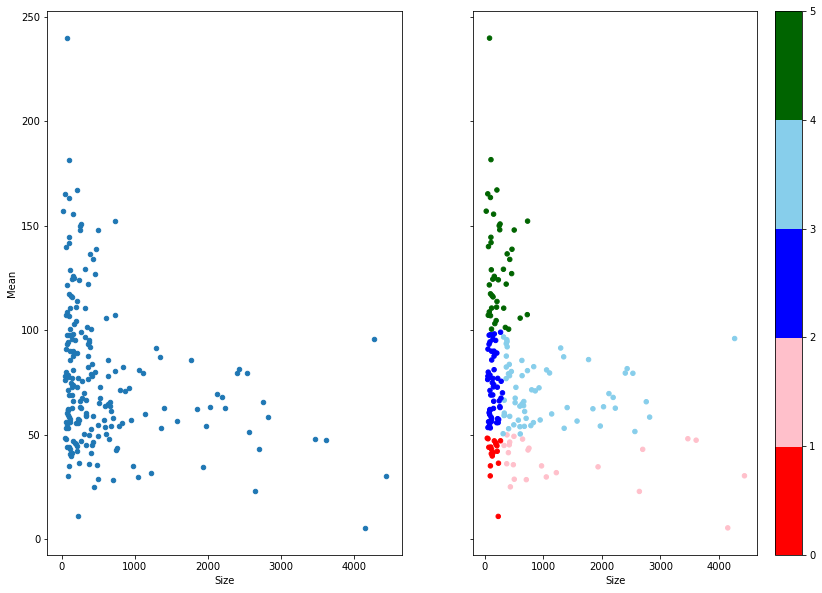

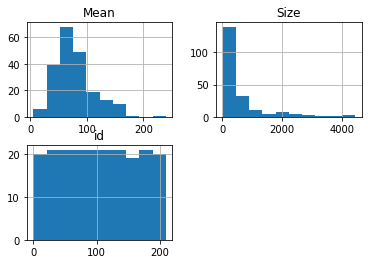

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# 1.普通のプロット

dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[0])
dff.plot(x='Size', y='Mean', kind='scatter', ax=axes.flatten()[1], c=c, cmap=cmap)
dff.hist()
# for x, y in dff.iterrows():
#     axes[1].annotate(int(y[0]), xy=(y[1],y[0]), size=2)
# # 2.離散値を色で表す
# df[0:150].plot(x='ad', y='ba', kind='scatter', c='ef', cmap='Blues', ax=axes.flatten()[1])
# # 3.離散値をバブルサイズで表す（ちょっと数は減らしてる）
# df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, ax=axes.flatten()[2])
# # 4.両方同時に使う
#df[0:150].plot.scatter(x='ad', y='ba', s=(df['su']-20)*3, c='ef', ax=axes.flatten()[3])

# Make random dataset
---

In [3]:
import numpy as np
import random

In [7]:
sw =  ['002', '007', '019', '021', '028', '035', '037', '038', '044', '046', '053', '068', '080', '083', '093', '094', '095', '099', '103', '106', '113', '127', '133', '134', '137', '145', '146', '155', '173', '176', '185', '193', '196', '197', '207']
bw =  ['042', '056', '067', '070', '102', '114', '139']
sm =  ['001', '003', '004', '006', '011', '012', '013', '024', '026', '027', '029', '031', '032', '039', '040', '045', '047', '048', '049', '050', '051', '052', '054', '057', '058', '060', '061', '062', '063', '064', '065', '066', '072', '074', '075', '076', '081', '084', '085', '086', '087', '089', '090', '091', '101', '104', '105', '108', '110', '112', '117', '118', '119', '121', '122', '124', '125', '126', '129', '130', '132', '136', '138', '141', '143', '144', '147', '148', '149', '150', '152', '153', '154', '156', '157', '159', '160', '162', '163', '164', '166', '169', '170', '171', '174', '175', '178', '179', '180', '183', '184', '187', '188', '190', '191', '195', '199', '200', '203', '204', '205', '206', '208', '209']
bm =  ['008', '025', '030', '055', '073', '078', '079', '088', '092', '107', '135', '172', '181', '186', '189', '192']
sb =  ['000', '009', '010', '014', '015', '016', '017', '018', '020', '022', '023', '033', '034', '036', '041', '043', '059', '069', '071', '077', '082', '096', '097', '098', '100', '109', '111', '115', '116', '120', '123', '128', '131', '140', '142', '158', '161', '167', '168', '177', '182', '198', '201', '202']
bb =  []
ignorePatient = ["005","151","165","194"]

In [8]:
random.shuffle(sw)
random.shuffle(bw)
random.shuffle(sm)
random.shuffle(bm)
random.shuffle(sb)
random.shuffle(bb)

In [12]:
a = len(sw)
b = len(bw)
c = len(sm)
d = len(bm)
e = len(sb)
f = len(bb)

        
validation = sw[:int(a/7)] + bw[:int(b/7)] + sm[:int(c/7)] \
              + bm[:int(d/7)] + sb[:int(e/7)] + bb[:int(f/7)] \

testing = sw[int(a/7):int(a/7)*2] + bw[int(b/7):int(b/7)*2] + sm[int(c/7):int(c/7)*2] \
              + bm[int(d/7):int(d/7)*2] + sb[int(e/7):int(e/7)*2] + bb[int(f/7):int(f/7)*2] \

training = sw[int(a/7)*2:] + bw[int(b/7)*2:] + sm[int(c/7)*2:] \
              + bm[int(d/7)*2:] + sb[int(e/7)*2:] + bb[int(f/7)*2:] \
              

    
print(len(validation))
print(len(testing))
print(len(training))
# testing.append("151")
# training.remove("151")
# x = random.randint(0,len(testing))
# training.append(testing[x])
# testing.remove(testing[x])
    
cnt = 0
ccc = validation+testing+training
while len(training)!=150:
    x = random.randint(0,len(training))
    testing.append(training[x])
    training.remove(training[x])
    x = random.randint(0,len(training))
    validation.append(training[x])
    training.remove(training[x])
    
print(len(validation))
print(len(testing))
print(len(training))

print("validation = ",validation)
print("training = ", training)
print("testing = ", testing)
for x in validation:
    if x in ignorePatient:
        print(x)

28
28
150
28
28
150
validation =  ['007', '145', '173', '021', '019', '067', '141', '045', '074', '199', '130', '184', '087', '117', '148', '170', '063', '091', '163', '188', '008', '079', '116', '016', '123', '096', '111', '015']
training =  ['068', '099', '037', '046', '196', '038', '080', '103', '113', '207', '094', '134', '095', '146', '137', '106', '185', '127', '028', '155', '093', '002', '053', '193', '133', '114', '056', '070', '139', '042', '195', '105', '011', '032', '112', '054', '051', '206', '187', '147', '191', '132', '064', '065', '006', '174', '204', '031', '159', '101', '118', '124', '152', '166', '072', '150', '160', '026', '164', '190', '138', '179', '039', '149', '049', '178', '040', '081', '085', '121', '157', '075', '062', '108', '029', '013', '090', '104', '060', '205', '203', '143', '183', '066', '169', '156', '027', '058', '154', '052', '180', '209', '048', '001', '153', '200', '110', '050', '122', '089', '084', '012', '144', '086', '024', '061', '135', '181', 

In [10]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import glob
import os

In [27]:
training = ['207', '080', '095', '099', '007', '028', '053', '137', '176', '106', '083', '127', '094', '103', '193', '019', '197', '037', '196', '035', '113', '146', '185', '093', '145', '102', '056', '042', '139', '067', '180', '061', '026', '174', '153', '001', '064', '075', '091', '129', '147', '058', '178', '085', '086', '203', '003', '138', '144', '051', '122', '024', '076', '205', '121', '063', '108', '027', '188', '184', '004', '160', '119', '164', '045', '130', '072', '049', '166', '154', '209', '143', '013', '163', '074', '081', '048', '052', '126', '087', '149', '117', '136', '012', '206', '040', '191', '054', '124', '066', '195', '187', '132', '057', '150', '060', '089', '104', '170', '159', '171', '169', '039', '125', '199', '011', '008', '073', '055', '107', '079', '092', '192', '030', '186', '181', '088', '172', '034', '018', '120', '082', '177', '014', '158', '109', '100', '131', '033', '010', '140', '069', '022', '123', '071', '023', '098', '116', '128', '043', '059', '161', '115', '097', '167', '017', '015', '201', '096', '202']
ignorePatient = ["005","151","165","194"]

In [51]:
data10 = {"mean" : [], "var" : []}
for x in training:
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org\image\case_00" + sx, "image1_*.mha"))
    
    
    mean = [0,0]
    var = [0,0]
    check = True
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
        
        if check:
            check = False
            img0Arrays = img0Array
            img1Arrays = img1Array
        
        else:
            img0Arrays = np.dstack([img0Arrays, img0Array])
            img1Arrays = np.dstack([img1Arrays, img1Array])
        
    data10["mean"].append([img0Arrays.mean(), img1Arrays.mean()])
    data10["var"].append([img0Arrays.var(), img1Arrays.var()])

In [52]:
print(np.array(data25["mean"]).mean(), np.array(data25["var"]).mean())
print(np.array(data50["mean"]).mean(), np.array(data50["var"]).mean())
print(np.array(data75["mean"]).mean(), np.array(data75["var"]).mean())
print(np.array(data10["mean"]).mean(), np.array(data10["var"]).mean())

12.218994473904107 214879.4315322188<br>
12.570158569339881 117897.898996187<br>
12.920030214222686 50587.0624435342<br>
11.863239299971964 341530.5333371568<br>

In [53]:
import csv # csvモジュールをインポート

In [56]:
with open("data25.csv", "w") as f: # 文字コードをShift_JISに指定
    writer = csv.writer(f, lineterminator="\n") # writerオブジェクトの作成 改行記号で行を区切る
    writer.writerows(data25["mean"]) # cs

# Make dataframe about alpha=0.25, 0.50, 0.75 (It doesn't finished)
---

In [ ]:
kidID = []
kidsNumber = []
kidTag = []
kidMean = []
kidStd = []
kidVar = []
kidMax = []
kidMin = []

canID = []
cansNumber = []
canTag = []
canMean = []
canStd = []
canVar = []
canMax = []
canMin = []

for x in range(210):
    
    sx = str(x).zfill(3)
    
    if sx in ignorePatient:
        continue
        
    paths0 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image0_*.mha"))
    paths1 = glob.glob(os.path.join("E:\slice\layers_1_hist_org_0.25\image\case_00" + sx, "image1_*.mha"))
    
    for path0, path1 in zip(paths0, paths1):
        img0 = sitk.ReadImage(path0)
        img1 = sitk.ReadImage(path1)
        img0Array = sitk.GetArrayFromImage(img0)
        img1Array = sitk.GetArrayFromImage(img1)
    
    ## Extracting data is finished

    for y in range(sliceNumber):
        imgArray = imageArray[y,:,:]
        labArray = labelArray[y,:,:]
        
        kidIndex = np.where(labArray==1)
        canIndex = np.where(labArray==2)
        
        if kidIndex[0].size!=0:
            kidImgArray = imgArray[kidIndex]
            kidMean.append(kidImgArray.mean())
            kidStd.append(kidImgArray.std())
            kidVar.append(kidImgArray.var())
            kidMax.append(kidImgArray.max())
            kidMin.append(kidImgArray.min())
        else:
            kidMean.append(None)
            kidStd.append(None)
            kidVar.append(None)
            kidMax.append(None)
            kidMin.append(None)
        
        if canIndex[0].size!=0:
            canImgArray = imgArray[canIndex]
            canMean.append(canImgArray.mean())
            canStd.append(canImgArray.std())
            canVar.append(canImgArray.var())
            canMax.append(canImgArray.max())
            canMin.append(canImgArray.min())
        
        else:
            canMean.append(None)
            canStd.append(None)
            canVar.append(None)
            canMax.append(None)
            canMin.append(None)
            
        kidID.append(x)
        kidsNumber.append(y)
        
        canID.append(x)
        cansNumber.append(y)
        
        kidTag.append("kidney")
        canTag.append("cancer")
    
ID = kidID + canID
sNumber = kidsNumber + cansNumber
Tag = kidTag + canTag
Mean = kidMean + canMean
Std = kidStd + canStd
Var = kidVar + canVar
Max = kidMax + canMax
Min = kidMax + canMin

df["id"] = ID
df["slice number"] = sNumber
df["tag"] = Tag
df["Mean"] = Mean
df["Std"] = Std
df["Var"] = Var
df["Max"] = Max
df["Min"] = Min


print(df)
df.set_index(["id", "slice number", "tag"], inplace=True)
print(df)
df.to_csv('sagital1.csv', sep=',', index=True, index_label = ["id", "slice number", "tag"])

In [2]:
import matplotlib.pyplot as plt

In [4]:
with open('/home/vmlab/Desktop/KIDNEY/text/result.txt') as f:
    file = f.readlines()

In [5]:
alpha = []
dice =[]
for x in file:
    xx = x.split()
    if xx[0][1].lower()=='l':
        alpha.append(1.0 - float(xx[1].replace('<br>', '')))
    elif xx[1][0].lower()=='c':
        dice.append(float(xx[2].replace('<br>', '')))
        
for x, y in zip(alpha, dice):
    print(x,y)

1.0 0.6168616106368008
0.95 0.6427303569773539
0.9 0.6331813067769961
0.85 0.6142015511082867
0.8 0.6127422154373728
0.75 0.6390143488447617
0.7 0.6144467124985238
0.6 0.6189194623422858
0.55 0.6227715693641677
0.5 0.6332673342763784
0.44999999999999996 0.6330643159830883
0.4 0.6154617736995323
0.35 0.6162038113721422
0.30000000000000004 0.6194164344665026
0.25 0.619761210861021
0.19999999999999996 0.6227163976428916
0.15000000000000002 0.615614442828826
0.09999999999999998 0.6066524546095309
0.050000000000000044 0.6128789202649746
0.0 0.6330005107201063


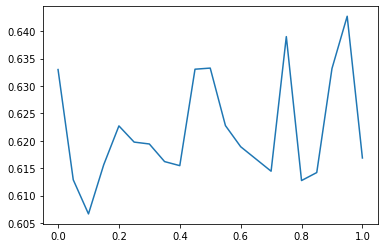

In [6]:
plt.plot(alpha, dice)

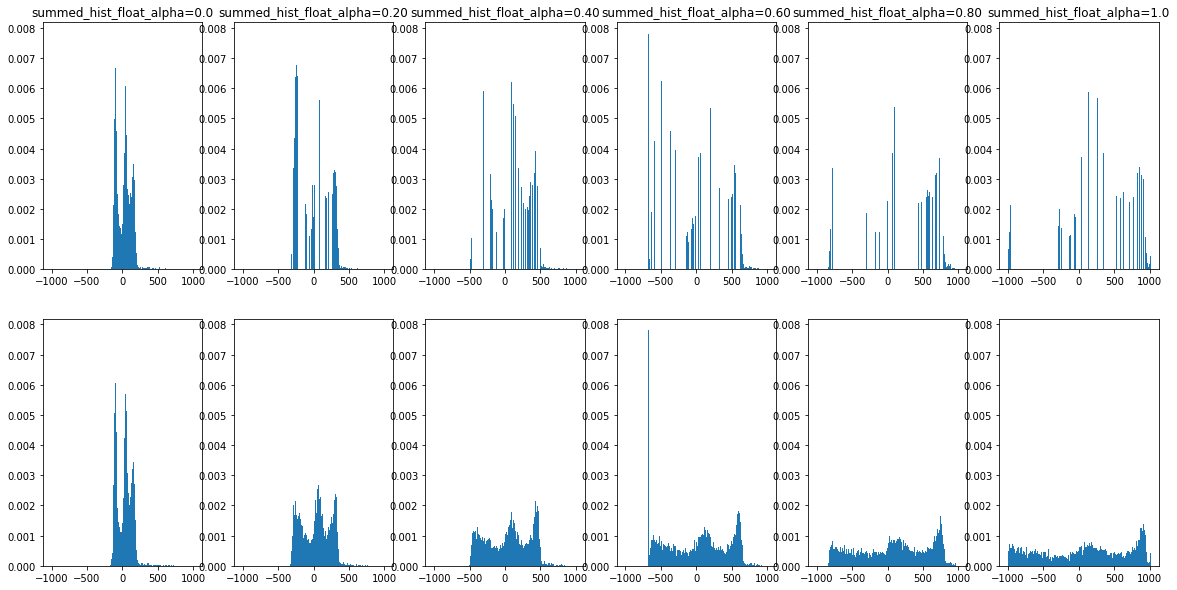

In [46]:
alpha = ['0.0', '0.20', '0.40', '0.60', '0.80', '1.0']
#alpha = ['1.0']
fig, axes = plt.subplots(2 ,6, figsize=(20, 10))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_int_alpha=" + a)
    axes[0][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/summed_hist_float_' + a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[0][ii].set_title("summed_hist_float_alpha=" + a)
    axes[1][ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)
   

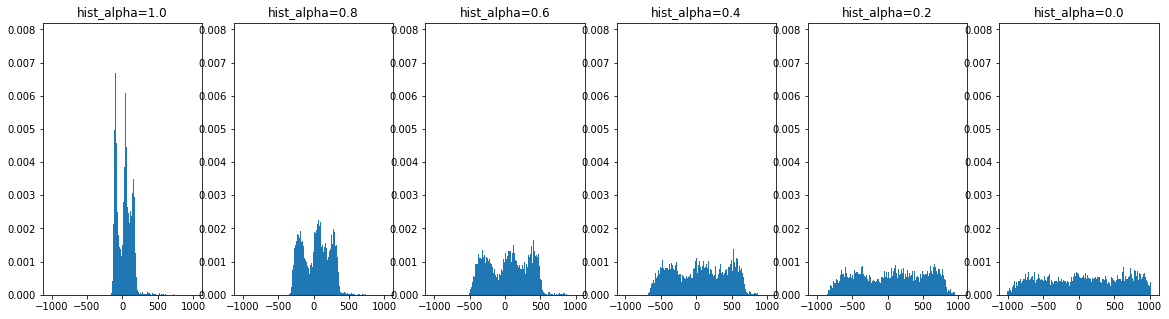

In [45]:
alpha = ['0.0', '0.2', '0.4', '0.6', '0.8', '1.0']
alpha.reverse()
fig, axes = plt.subplots(1 ,6, figsize=(20, 5))
for ii, a in enumerate(alpha):
    i = sitk.ReadImage('/home/vmlab/Desktop/data/slice/hist_'+ a + '/image/case_00000/image0_13.mha')
    ia = sitk.GetArrayFromImage(i)
    axes[ii].set_title("hist_alpha=" + a)
    axes[ii].hist(ia.ravel(), 2049, [-1024, 1024], density=True)

In [30]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
df = pd.read_csv("dfAboutKidneyAndCancer.csv")
df.head()

,Unnamed: 0,id,slice number,tag,Mean,Std,Var,Max,Min,Size
0,162,0,162,kidney,-37.253151,9.672718,93.561468,-11.861316,-11.861316,22
1,163,0,163,kidney,37.572537,49.860718,2486.091249,127.743541,127.743541,83
2,164,0,164,kidney,85.865282,86.790756,7532.635240,216.219592,216.219592,147
3,165,0,165,kidney,99.003225,94.184951,8870.804999,241.380014,241.380014,247
4,166,0,166,kidney,129.435100,84.773216,7186.498072,251.062135,251.062135,333


In [38]:
df_can = df.query("tag=='cancer'")
df_can_id = df_can.groupby('id')
df_can_id.head()

,Unnamed: 0,id,slice number,tag,Mean,Std,Var,Max,Min,Size
39414,107526,0,192,cancer,108.503576,29.433465,866.328841,159.202129,60.756507,9
39415,107527,0,193,cancer,121.447670,32.812393,1076.653144,178.043149,55.206411,20
39416,107528,0,194,cancer,131.009104,46.715202,2182.310071,204.502843,1.421013,46
39417,107529,0,195,cancer,141.070491,53.882059,2903.276279,247.621144,-15.397805,69
39418,107530,0,196,cancer,146.101227,62.604175,3919.282724,274.279406,-27.368338,95
...,...,...,...,...,...,...,...,...,...,...
52486,214482,209,325,cancer,5.562831,34.561447,1194.493588,62.024553,-45.347139,9
52487,214483,209,326,cancer,23.459182,31.698505,1004.795245,63.988746,-50.938850,17
52488,214484,209,327,cancer,40.161049,30.769446,946.758797,83.584497,-30.606094,25
52489,214485,209,328,cancer,48.279034,25.826263,666.995864,86.256312,-13.109755,36


In [174]:
df_can_id_size = df_can_id["Size"].mean()
df_can_size_sort = df_can_id_size.sort_values()
df_can_id_size = pd.DataFrame(df_can_id_size, columns = [ 'Size'])
print(df_can_id_size)
df_can_id_size.query('Size < 200').sort_values('Size').head()

           Size
id             
0    138.666667
1     82.916667
2    326.844828
3    150.324324
4    245.261905
..          ...
205  111.966667
206  405.036364
207  108.321429
208   70.035714
209   51.333333

[206 rows x 1 columns]


,Size
id,
120,21.666667
19,39.333333
72,46.550000
123,48.208333
156,50.212121


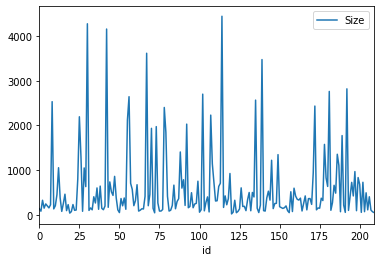

In [158]:
df_can_id_size.plot()


# Divide kidney into a separate space
---

In [1]:
import cv2
import SimpleITK as sitk
from cut import caluculate_area

In [2]:
img = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/imaging.nii.gz')
imgArray = sitk.GetArrayFromImage(img)
label = sitk.ReadImage('/home/vmlab/Desktop/data/kits19/case_00120/segmentation.nii.gz')
labelArray = sitk.GetArrayFromImage(label)
labelArray.shape

(545, 545, 95)

In [56]:
SL, CL, AL = labelArray.shape
print(SL, CL, AL)

545 545 95


In [1]:
def searchBound(labelArray, length, axis):
    encounter = False
    startIdx = []
    endIdx = []
    if axis == 'sagittal':
        for l in range(length):
            sliceArray = labelArray[l, :, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

    if axis == 'coronal':
        for l in range(length):
            sliceArray = labelArray[:, l, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx        

    if axis == 'axial':
        for l in range(length):
            sliceArray = labelArray[:, :, l]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

def printchk(x):
    for s, v in globals().items():
        if id(v) == id(x):
            print('{} : {}'.format(s, x))
            break
            
    return 

def extractBoundingBox(labelArray, AL, CL):
    print("From {} to ".format(labelArray.shape), end="")
    
    startIdx, endIdx = searchBound(labelArray, AL, 'axial')
    labelArray = labelArray[:, :, startIdx[0] -1 : endIdx[0] + 1]
    
    print(labelArray.shape)
    
    print("From {} to ".format(labelArray.shape), end="")
    startIdx, endIdx = searchBound(labelArray, CL, 'coronal')
    labelArray = labelArray[:, startIdx[0] -1 : endIdx[0] + 1, :]
    
    print(labelArray.shape)
    
    return labelArray

def saveImage(saveImgArray, savePath, img):
    saveImg = sitk.GetImageFromArray(saveImgArray)
    saveImg.SetDirection(img.GetDirection())
    saveImg.SetOrigin(img.GetOrigin())
    saveImg.SetSpacing(img.GetSpacing())
    
    print('Saving image to ', savePath)
    sitk.WriteImage(saveImg, savePath, True)
    
    return

In [5]:
startIdx, endIdx = searchBound(labelArray, SL, 'sagittal')
printchk(startIdx)
printchk(endIdx)

startIdx : [145, 331]
endIdx : [220, 410]


In [6]:
leftArray = labelArray[startIdx[0] - 1 : endIdx[0] + 1, :, :]
rightArray = labelArray[startIdx[1] - 1 : endIdx[1] + 1, :, :]
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

leftArray shapes :  (77, 545, 95)
rightArray shapes :  (81, 545, 95)


In [7]:
leftArray = extractBoundingBox(leftArray, AL, CL)
rightArray = extractBoundingBox(rightArray, AL, CL)
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

From (77, 545, 95) to (77, 545, 26)
From (77, 545, 26) to (77, 107, 26)
From (81, 545, 95) to (81, 545, 34)
From (81, 545, 34) to (81, 73, 34)
leftArray shapes :  (77, 107, 26)
rightArray shapes :  (81, 73, 34)


In [8]:
saveImage(leftArray, 'test/left.mha', label)
saveImage(rightArray, 'test/right.mha', label)

Saving image to  test/left.mha
Saving image to  test/right.mha


# Use OBB
---

In [59]:
from pyobb.obb import OBB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi, cos, sin, sqrt

In [5]:
# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

NameError: name 'pi' is not defined

In [61]:
v = sphere(1, (0,0,0))

In [62]:
x = []
y = []
z = []
for xx, yy, zz in v:
    x.append(xx)
    y.append(yy)
    z.append(zz)

In [63]:
a = []
b = []
c = []
for xx, yy, zz in obb.points:
    a.append(xx)
    b.append(yy)
    c.append(zz)


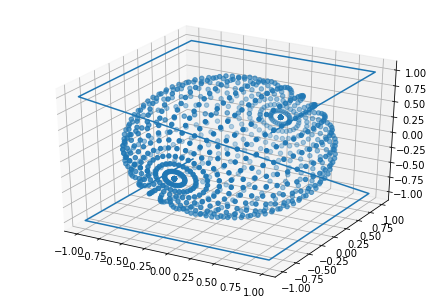

In [64]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)
ax.plot(a, b, c)
plt.show()

# Make bouding box and cut it
---

In [1]:
import SimpleITK as sitk
import numpy as np
from cut import caluculate_area
from pyobb.obb import OBB
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import pi
from functions import saveImage

In [2]:
def searchBound(labelArray, length, axis):
    encounter = False
    startIdx = []
    endIdx = []
    if axis == 'sagittal':
        for l in range(length):
            sliceArray = labelArray[l, :, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

    if axis == 'coronal':
        for l in range(length):
            sliceArray = labelArray[:, l, :]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx        

    if axis == 'axial':
        for l in range(length):
            sliceArray = labelArray[:, :, l]
            area = caluculate_area(sliceArray)
            if area != 0 and not encounter:
                encounter = True
                startIdx.append(l)

            if area == 0 and encounter:
                encounter = False
                endIdx.append(l)

        return startIdx, endIdx

def printchk(x):
    for s, v in globals().items():
        if id(v) == id(x):
            print('{} : {}'.format(s, x))
            break
            
    return 


def extractBoundingBox(labelArray, AL, CL):
    print("From {} to ".format(labelArray.shape), end="")
    
    startIdx, endIdx = searchBound(labelArray, AL, 'axial')
    labelArray = labelArray[:, :, startIdx[0] -1 : endIdx[0] + 1]
    
    print(labelArray.shape)
    
    print("From {} to ".format(labelArray.shape), end="")
    startIdx, endIdx = searchBound(labelArray, CL, 'coronal')
    labelArray = labelArray[:, startIdx[0] -1 : endIdx[0] + 1, :]
    
    print(labelArray.shape)
    
    return labelArray

def pythagorian(x, y):#x, y = (x cordinate, y cordinate, zcordinate)
    l = 0
    d = len(x)
    for i in range(d):
        l += (x[i] - y[i])**2
    
    return math.sqrt(l)

In [142]:
# Read image
img = sitk.ReadImage('/Users/tanimotoryou/Documents/lab/program/case_00120/imaging.nii.gz')
imgArray = sitk.GetArrayFromImage(img)
label = sitk.ReadImage('/Users/tanimotoryou/Documents/lab/program/case_00120/segmentation.nii.gz')
labelArray = sitk.GetArrayFromImage(label)
SL, CL, AL = labelArray.shape
print(SL, CL, AL)

545 545 95


In [144]:
# Find a border dividing the kidney into a separate space 
startIdx, endIdx = searchBound(labelArray, SL, 'sagittal')
printchk(startIdx)
printchk(endIdx)
# Divide the kidney into leftArray and rightArray
leftArray = labelArray[ : startIdx[1] - 1, :, :]
rightArray = labelArray[endIdx[0] + 1 : , :, :]
print('leftArray shapes : ', leftArray.shape)
print('rightArray shapes : ', rightArray.shape)

#Experiment
leftImgArray = imgArray[ : startIdx[1] - 1,:,:]

startIdx : [145, 331]
endIdx : [220, 410]
leftArray shapes :  (330, 545, 95)
rightArray shapes :  (324, 545, 95)


In [ ]:
# Find kidney region
#saveImage(leftArray, img, "test/pre.mha")
idx = np.where(leftArray > 0)

In [ ]:
# Preprocessing for OBB
vertics = np.stack([*idx], axis=-1)
print("vertics",vertics[0:10])

# Implement OBB
obb = OBB.build_from_points(vertics)

In [ ]:
# Plot the kidney and the bouding box
a = []
b = []
c = []
cc = []
colors = ["red", "blue", "yellow", "green", "orange", "pink", "black", "skyblue"]
i = 0
for xx, yy, zz in obb.points:
    a.append(xx)
    b.append(yy)
    c.append(zz)
    cc.append(i)
    i += 1
cmap = ListedColormap(colors)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(*idx, alpha=0.005, color="gray")
ax.scatter(a, b, c, c=cc, cmap=cmap)  
plt.show()

In [10]:
# Output 8 vertics of bouding box
obb.points

[array([147.8792208 , 230.24721848,  47.75358473]),
 array([143.39991205, 335.29806081,  43.67420539]),
 array([218.04274209, 338.79603414,  51.79229411]),
 array([222.52205084, 233.74519181,  55.87167344]),
 array([140.88155616, 336.07682752,  66.49399855]),
 array([145.36086491, 231.02598519,  70.57337789]),
 array([220.00369495, 234.52395852,  78.6914666 ]),
 array([215.5243862 , 339.57480086,  74.61208727])]

In [11]:
# Minimum vertics for defining bounding box per vertex
index = (((0, 1), (0, 3), (0, 5)),
         ((1, 0), (1, 2), (1, 4)),
         ((2, 1), (2, 3), (2, 7)),
         ((3, 0), (3, 2), (3, 6)),
         ((4, 1), (4, 5), (4, 7)),
         ((5, 0), (5, 4), (5, 6)),
         ((6, 3), (6, 5), (6, 7)), 
         ((7, 2,), (7, 4), (7, 6)))

In [193]:
def getSortedDistance(obbPoints, index):
    length = []
    out = []
    for i in index:
        l = pythagorian(obbPoints[i[0]], obbPoints[i[1]])
        length.append((l, (obbPoints[i[0]], obbPoints[i[1]])))
    
    length = sorted(length, reverse=True)
    for _ , i in length:
        out.append(i)
    
    return out

def getRadianFromCoords(x, y, axis):
    #axis : x->0, y->1, z->2
    g = []
    d = len(x)
    esp = 10**(-9)
    for i in range(d):
        g.append(y[i] - x[i])
        
    if axis == 0:
        return atan2(g[2], g[1])
        #return g[1] / g[2]
    
    if axis == 1:
        return atan2(g[2], g[0])
        #return g[0] / g[2]
    
    if axis == 2:
        return atan2(g[1], g[0])
        #return g[1] / g[2]
        
        
def makeRotationMatrix(radian, axis):
    if axis == 0:
        matrix = np.array([[1, 0, 0], 
                           [0, cos(radian), (-1) * sin(radian)],
                           [0, sin(radian), cos(radian)]])
        
        return matrix
    
    if axis == 1:
        matrix = np.array([[cos(radian), 0, (-1) * sin(radian)],
                           [0, 1, 0], 
                           [sin(radian), 0, cos(radian)]])
        
        return matrix
    
    if axis == 2:
        matrix = np.array([[cos(radian), (-1) * sin(radian), 0], 
                           [sin(radian), cos(radian), 0],
                           [0, 0, 1]])
        
        return matrix

def multiplyMatrix(matrix, points):
    l = len(points)
    p = []
    for x in range(l):
        p.append(matrix @ points[x])
    
    return p


def makeCompleteMatrix(points, ppp):
    p = [points[0][0], points[0][1], points[1][1], points[2][1]]
    
    radianX = getRadianFromCoords(p[0], p[1], 0)
    print(math.degrees(radianX))
    
    matrixX = makeRotationMatrix(pi/2 - radianX, 0)
    p = multiplyMatrix(matrixX, p)
    print([x.astype(int) for x in p])
    
    radianY = getRadianFromCoords(p[0],p[1], 1)
    print(math.degrees(radianY))  
    
    matrixY = makeRotationMatrix(pi/2 - radianY, 1)
    p = multiplyMatrix(matrixY, p)
    print([x.astype(int) for x in p])
    
    radianZ = getRadianFromCoords(p[0],p[2], 2)
    matrixZ = makeRotationMatrix(pi/2 - radianZ, 2)
    print(math.degrees(radianZ))

    p = multiplyMatrix(matrixZ, p)
    print([np.where(x > 0, x + 0.5, x - 0.5).astype(int) for x in p])
    
    #print([np.where(x+ppp > 0, x+ppp + 0.5, x + ppp- 0.5).astype(int) for x in p])
    
    return matrixZ @ matrixY @ matrixX, p

In [199]:
def determineAxis(radian):
    if pi/4 < radian < 3*pi/4 or -3*pi/4 < radian < -pi/4:
        return "vertical"
    
    if -pi/4 <= radian <= pi/4 or 3*pi/4 <= radian <= 2*pi or -2*pi <= radian <= -3*pi/4: 
        return "horizontal"
    
def determineRadian(radian):
    axis = determineAxis(radian)
    print(axis)
    if axis=="horizontal":
        return -radian, axis
    
    if axis=="vertical":
        return pi/2 - radian, axis

In [280]:
def makeCompleteMatrix(points, ppp):
    p = [points[0][0], points[0][1], points[1][1], points[2][1]]
    
    radianX = getRadianFromCoords(p[0], p[1], 0)
    print(math.degrees(radianX))
    radianX, direction = determineRadian(radianX)
    print(math.degrees(radianX))
    
    
    matrixX = makeRotationMatrix(radianX, 0)
    p = multiplyMatrix(matrixX, p)
    print([x.astype(int) for x in p])
    
    if direction=="horizontal":
        radianY = getRadianFromCoords(p[0],p[2], 1)
    
    else:
        radianY = getRadianFromCoords(p[0], p[1], 1)
        
    print(math.degrees(radianY))  
    radianY, _ = determineRadian(radianY)
    print(math.degrees(radianY))

    matrixY = makeRotationMatrix(radianY, 1)
    p = multiplyMatrix(matrixY, p)
    print([x.astype(int) for x in p])
    
    
    radianZ = getRadianFromCoords(p[0],p[2], 2)
    print(math.degrees(radianZ))
    radianZ, _ = determineRadian(radianZ)
    print(math.degrees(radianZ))
    
    matrixZ = makeRotationMatrix(radianZ, 2)
    p = multiplyMatrix(matrixZ, p)
    print([np.where(x > 0, x + 0.5, x - 0.5).astype(int) for x in p])
    
    #print([np.where(x+ppp > 0, x+ppp + 0.5, x + ppp- 0.5).astype(int) for x in p])
    
    return matrixZ @ matrixY @ matrixX, p

In [281]:
# Find the closest vertex to origin
minVertex = sorted([(x[0]**2 + x[1]**2 + x[2]**2, i) for i, x in enumerate(obb.points)])[0][1]
printchk(minVertex)
# Calucualte the length of each side of bouding box and output in decending order
points = getSortedDistance(obb.points, index[minVertex])
ppp = points[0][0]

#Slide to locate point[0][0] into (0,0,0)
#points = [p - points[0][0] for p in points]

#printchk(points)
rotationMatrix, p = makeCompleteMatrix(points, ppp)

minVertex : 0
-2.223816908353208
horizontal
2.223816908353208
[array([147, 228,  56]), array([143, 333,  56]), array([222, 231,  64]), array([145, 228,  79])]
6.305355535890838
horizontal
-6.305355535890838
[array([153, 228,  40]), array([148, 333,  40]), array([228, 231,  40]), array([153, 228,  63])]
2.425003103875007
horizontal
-2.425003103875007
[array([163, 222,  40]), array([163, 327,  41]), array([238, 222,  40]), array([163, 221,  63])]


minVertex : 0  
-2.223816908353208  
horizontal  
2.223816908353208  
[array([147, 228,  56]), array([143, 333,  56]), array([222, 231,  64]), array([145, 228,  79])]  
6.305355535890838  
horizontal  
-6.305355535890838  
[array([153, 228,  40]), array([148, 333,  40]), array([228, 231,  40]), array([153, 228,  63])]   
2.425003103875007   
horizontal   
-2.425003103875007  
[array([163, 222,  40]), array([163, 327,  41]), array([238, 222,  40]), array([163, 221,  63])]  

In [246]:
rotationMatrix, p = makeCompleteMatrix(points, ppp)

-2.223816908353208
horizontal
2.223816908353208
[array([147, 228,  56]), array([143, 333,  56]), array([222, 231,  64]), array([145, 228,  79])]
6.305355535890838
horizontal
-6.305355535890838
[array([153, 228,  40]), array([148, 333,  40]), array([228, 231,  40]), array([153, 228,  63])]
2.425003103875007
horizontal
-2.425003103875007
[array([163, 222,  40]), array([163, 327,  41]), array([238, 222,  40]), array([163, 221,  63])]


In [247]:
print(leftArray.shape)
print(rotationMatrix.shape)
print(rotationMatrix)

(330, 545, 95)
(3, 3)
[[ 0.99306057  0.04653762  0.1080044 ]
 [-0.0420557   0.99817169 -0.0434119 ]
 [-0.10982722  0.03856845  0.99320212]]


In [248]:
#SL, CL, AL   
SL, CL, AL = leftArray.shape
# For affine transformation, make dummyArray that is a matrix with the coordinates for each pixels
x, y, z = np.mgrid[:SL, :CL, :AL]
dummyArray = np.stack([x, y, z], axis=-1)
print(outputArray.shape)

(330, 545, 95, 3)


In [249]:
# For affine transformation, make inverse matrix
invAffine = np.linalg.inv(rotationMatrix)
# Caluculate the coordinates before conversion that each pixel after conversion should refer to
refCoords = np.einsum('ijkm, lm->ijkl', dummyArray, invAffine)
refCoords.shape

(330, 545, 95, 3)

In [250]:
def clipXYZ(array, imgShape):
    l =[]
    for i in range(3):
        l.append(np.clip(array[...,i], 0, imgShape[i] - 1))
    
    return np.stack(l, axis=-1)

In [251]:
# Nearest neighbor
refCoordsNearest = np.where(refCoords > 0, refCoords + 0.5, refCoords - 0.5).astype(int)
refCoordsNearest = clipXYZ(refCoordsNearest, leftArray.shape)
p = [np.where(pp > 0, pp + 0.5, pp - 0.5).astype(int) for pp in p]
refCoordsNearest.shape

(330, 545, 95, 3)

In [252]:
rotatedImageArray = leftImgArray[refCoordsNearest[...,0], refCoordsNearest[..., 1], refCoordsNearest[..., 2]]
print(rotatedImageArray.shape)
rotatedImageArray = rotatedImageArray[p[0][0] : p[2][0] + 1, p[0][1] : p[1][1] + 1, p[0][2] : p[3][2] + 1]
rotatedImageArray.shape

(330, 545, 95)


(76, 106, 24)

In [253]:
saveImage(rotatedImageArray, label, "test/test.mha")

Saving image to test/test.mha...
Done.


In [254]:
np.where(rotatedImageArray>0)

(array([ 0,  0,  0, ..., 75, 75, 75]),
 array([  0,   0,   0, ..., 105, 105, 105]),
 array([ 0,  1,  2, ..., 21, 22, 23]))

In [255]:
# Linear interpolation

# Caluculate 8 vertics around
linearCoords = {} #linearCoords['xyz']
linearCoords['000'] = refCoords.astype(int)
linearCoords["100"] = linearCoords['000'] + [1, 0, 0]
linearCoords["010"] = linearCoords['000'] + [0, 1, 0] 
linearCoords["001"] = linearCoords['000'] + [0, 0, 1]
linearCoords["110"] = linearCoords['000'] + [1, 1, 0]
linearCoords["101"] = linearCoords['000'] + [1, 0, 1]
linearCoords["011"] = linearCoords['000'] + [0, 1, 1]
linearCoords["111"] = linearCoords['000'] + [1, 1, 1]
print(linearCoords['000'][0,0,3,:])
print(linearCoords['100'][0,0,3,:])
print(linearCoords['010'][0,0,3,:])
print(linearCoords['001'][0,0,3,:])
print(linearCoords['110'][0,0,3,:])
print(linearCoords['101'][0,0,3,:])
print(linearCoords['011'][0,0,3,:])
print(linearCoords['111'][0,0,3,:])
linearCoords['000'].shape

[0 0 2]
[1 0 2]
[0 1 2]
[0 0 3]
[1 1 2]
[1 0 3]
[0 1 3]
[1 1 3]


(330, 545, 95, 3)

In [256]:
diff = (refCoords - linearCoords['000'])
alpha = diff[..., 0]
beta = diff[..., 1]
gamma = diff[..., 2]
print(alpha.shape, beta.shape, gamma.shape)

(330, 545, 95) (330, 545, 95) (330, 545, 95)


In [257]:
#Caluculate weights
linearWeight = {}

linearWeight['000'] = (1 - alpha) * (1 - beta) * (1 - gamma)
linearWeight['100'] = alpha * (1 - beta) * (1 - gamma)
linearWeight['010'] = (1 - alpha) * beta * (1 - gamma)
linearWeight['001'] = (1 - alpha) * (1 - beta) * gamma
linearWeight['110'] = alpha * beta * (1 - gamma)
linearWeight['101'] = alpha * (1 - beta) * gamma
linearWeight['011'] = (1 - alpha) * beta * gamma
linearWeight['111'] = alpha * beta * gamma
linearWeight['000'].shape

(330, 545, 95)

In [259]:
linearWithWeight = {}
for direction in linearCoords.keys():
    coords = linearCoords[direction]
    weight = linearWeight[direction]
    coords = clipXYZ(coords, imgArray.shape)

    linearWithWeight[direction]  = np.einsum('ijk, ijk->ijk', weight,imgArray[coords[..., 0], coords[..., 1], coords[..., 2]] )
    
rotatedImageArray = sum(linearWithWeight.values())[p[0][0] : p[2][0] + 1, p[0][1] : p[1][1] + 1, p[0][2] : p[3][2] + 1]

In [260]:
saveImage(rotatedImageArray, img, "test/linear.mha")

Saving image to test/linear.mha...
Done.


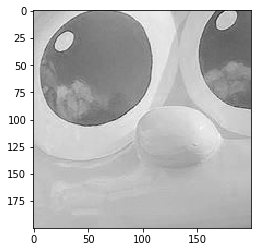

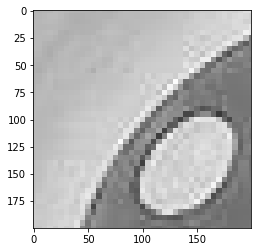

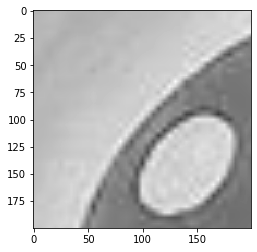

In [140]:
def img_show(img : np.ndarray, cmap = 'gray', vmin = 0, vmax = 255, interpolation = 'none') -> None:
    '''np.arrayを引数とし、画像を表示する。'''

    #dtypeをuint8にする
    img = np.clip(img,vmin,vmax).astype(np.uint8)

    #画像を表示
    plt.imshow(img, cmap = cmap, vmin = vmin, vmax = vmax, interpolation = interpolation)
    plt.show()
    plt.close()

img = plt.imread('/Users/tanimotoryou/Downloads/IMG_8396.jpeg')[100:300,100:300,1]
img_show(img)

#高さ3、幅4の画像を作る
height, width = 3,4
x_len, y_len = img.shape
x_len = 200
y_len = 200
#mgridでx座標の行列、y座標の行列を作成
x, y = np.mgrid[:x_len,:y_len]

#dstackでx座標、y座標、1を組み合わせる
xy_after = np.dstack((x,y,np.ones((x_len, y_len))))
xy_after.shape

#縦横に2倍拡大するアフィン変換
affin = np.matrix('5,0,0;0,5,0;0,0,1')

#逆行列
inv_affin = np.linalg.inv(affin)

#行列の掛け算をアインシュタイン和で計算
ref_xy = np.einsum('ijk,lk->ijl',xy_after,inv_affin)[...,:2]
ref_xy.shape


#参照する座標を計算
ref_nearmost_xy = (ref_xy + 0.5).astype(int)
img_nearmost = img[ref_nearmost_xy[...,0],ref_nearmost_xy[...,1]]

img_show(img_nearmost)

linear_xy = {}
linear_xy['upleft'] = ref_xy.astype(int)
linear_xy['downleft'] = linear_xy['upleft'] + [1,0]
linear_xy['upright']= linear_xy['upleft'] + [0,1]
linear_xy['downright'] = linear_xy['upleft'] + [1,1]

upleft_diff = ref_xy - linear_xy['upleft']

#(1-xの差)と(1-yの差)の積を計算
linear_weight = {}
linear_weight['upleft'] = (1-upleft_diff[...,0])*(1-upleft_diff[...,1])
linear_weight['downleft'] = upleft_diff[...,0]*(1-upleft_diff[...,1])
linear_weight['upright'] = (1-upleft_diff[...,0])*upleft_diff[...,1]
linear_weight['downright'] = upleft_diff[...,0]*upleft_diff[...,1]

linear_with_weight = {}
for direction in linear_xy.keys():
    xy = linear_xy[direction]
    weight = linear_weight[direction]
    
    linear_with_weight[direction] = np.einsum('ij,ij->ij',weight,img[xy[...,0],xy[...,1]])
img_linear = sum(linear_with_weight.values())
img_show(img_linear)